In [1]:
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
from xopt import Xopt
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions
from lume_model.torch import LUMEModule

from utils import NegativeTransverseBeamSize, MismatchedGroundTruth
from utils import load_surrogate, running_max, create_vocs, print_runtime
from custom_mean import LinearCalibration

In [2]:
# load surrogate model and define objective
surrogate = load_surrogate("configs/lcls_variables.yml", "configs/normalization.json", "torch_model.pt")
surrogate._model.eval()
surrogate._model.requires_grad_(False)

objective_name = "negative_sigma_xy"
vocs = create_vocs(surrogate, objective_name)

surrogate_module = LUMEModule(surrogate, vocs.variable_names, ["sigma_x", "sigma_y"])
surrogate_module.eval()
surrogate_module.requires_grad_(False)

Objective = NegativeTransverseBeamSize
ground_truth = Objective(surrogate_module)

# Xopt evaluator function
def evaluate(input_dict):
    model_result = surrogate.evaluate(input_dict)
    obj_kwargs = {key:model_result[key] for key in surrogate_module.output_order}
    obj_value = Objective.function(**obj_kwargs).detach().item()
    return {objective_name: obj_value}

In [3]:
# define custom mean
x_dim = len(surrogate_module.feature_order)
y_dim = len(vocs.objective_names)
x_shift = torch.zeros(x_dim)
x_scale = torch.ones(x_dim)
y_shift = torch.tensor([0.2])
y_scale = torch.tensor([1.0])

mismatched_gt = MismatchedGroundTruth(
    x_dim=x_dim,
    ground_truth=ground_truth,
    x_shift=x_shift,
    x_scale=x_scale,
    y_shift=y_shift,
    y_scale=y_scale,
)

custom_mean = LinearCalibration(
    mismatched_gt,
    x_dim=x_dim,
    y_dim=1,
)

In [4]:
n_init = 3
inputs_init = pd.DataFrame(vocs.random_inputs(n=n_init))  # , seed=0
outputs = [evaluate(inputs_init.to_dict(orient="index")[i])[objective_name] for i in range(len(inputs_init))]
outputs_init = pd.DataFrame({objective_name: outputs})
data_init = pd.concat([inputs_init, outputs_init], axis=1)
data_init

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy
0,0.234596,8.951924,0.245324,-0.006922,0.005677,-7.510611,6.541448,3.965880,-1.040539,1.776751,-5.418752,-3.559591,6.713212,250.0,58000000.0,70000000.0,-4.509301
1,0.249013,5.934151,0.230000,0.002243,0.002717,-22.130419,7.577991,1.041875,-3.802981,1.243850,-6.405582,-4.573036,4.464341,250.0,58000000.0,70000000.0,-5.641874
2,0.357524,7.248244,0.205032,0.007874,0.000897,-10.407124,9.652559,1.904276,-1.347252,5.401055,-0.474979,-2.979619,4.514739,250.0,58000000.0,70000000.0,-3.284544


In [5]:
n_step = 50
model_options = ModelOptions(
    name="trainable_mean_standard",
    mean_modules={objective_name: custom_mean}
)
generator_options = BayesianOptions(model=model_options)
generator = ExpectedImprovementGenerator(vocs, options=generator_options)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs, data=data_init)

t0 = time.time()
for i in range(n_step):
    X.step()

# print runtime
print_runtime(t0, time.time())

Runtime: 48.63 min


In [6]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy,xopt_runtime,xopt_error
0,0.234596,8.951924,0.245324,-0.006922,0.005677,-7.510611,6.541448,3.965880,-1.040539,1.776751,-5.418752,-3.559591,6.713212,250.0,58000000.0,70000000.0,-4.509301,NaN,NaN
1,0.249013,5.934151,0.230000,0.002243,0.002717,-22.130419,7.577991,1.041875,-3.802981,1.243850,-6.405582,-4.573036,4.464341,250.0,58000000.0,70000000.0,-5.641874,NaN,NaN
2,0.357524,7.248244,0.205032,0.007874,0.000897,-10.407124,9.652559,1.904276,-1.347252,5.401055,-0.474979,-2.979619,4.514739,250.0,58000000.0,70000000.0,-3.284544,NaN,NaN
4,0.443515,3.524550,0.227926,0.008972,-0.001736,-5.024216,6.222431,3.586230,-3.400550,5.189021,-6.897355,-2.644553,4.047948,250.0,58000000.0,70000000.0,-1.048286,0.000556,False
5,0.425003,10.557162,0.194829,0.003884,0.000515,-15.054355,-17.037142,1.154946,-2.701657,3.555478,-1.630480,-0.015605,4.986956,250.0,58000000.0,70000000.0,-4.645056,0.000596,False
6,0.446629,8.101623,0.226263,0.003319,0.008311,-19.939321,6.199776,3.813466,-2.026542,2.112125,-0.950733,-3.775581,6.178342,250.0,58000000.0,70000000.0,-1.885872,0.000549,False
7,0.281443,11.625737,0.249683,-0.006169,-0.008257,-21.291576,-5.775334,3.809550,-1.242657,6.369768,-5.600544,0.556875,3.365880,250.0,58000000.0,70000000.0,-1.698924,0.000544,False
8,0.269030,5.062753,0.252599,-0.007690,0.004131,-0.647930,-11.386039,2.770301,-2.668120,3.097716,-6.064383,0.864765,3.430838,250.0,58000000.0,70000000.0,-2.543138,0.000555,False
9,0.428085,3.726840,0.216149,0.002474,-0.009611,8.813621,-24.589226,2.170633,-3.534079,3.066611,-4.920875,-1.835536,5.175920,250.0,58000000.0,70000000.0,-1.666772,0.000667,False
10,0.371241,9.627480,0.246101,0.009732,0.007914,-19.320863,-0.346828,3.714325,-3.205040,3.717495,-1.618644,0.193023,5.583275,250.0,58000000.0,70000000.0,-1.898643,0.000561,False


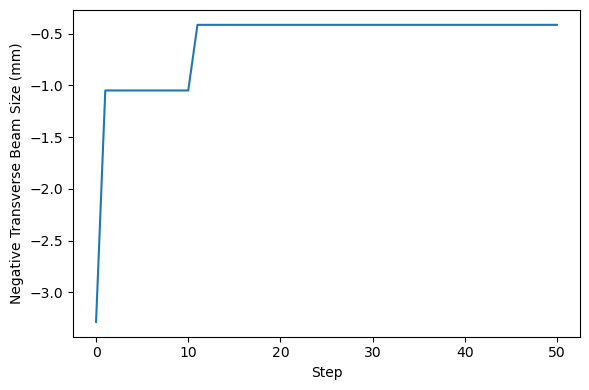

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(n_step + 1)
y = torch.from_numpy(X.data[objective_name].values)
ax.plot(x, running_max(y.squeeze())[n_init - 1:], "C0-")
ax.set_xlabel("Step")
ax.set_ylabel("{} ({})".format(ground_truth.name, ground_truth.unit))
fig.tight_layout()

In [8]:
# evaluate input calibration
if hasattr(custom_mean, "x_shift") and hasattr(custom_mean, "x_scale"):
    print("{:<5s} {:>10s} {:>10s} {:>10s} {:>10s}".format("x_dim", "x_shift", "learned", "x_scale", "learned"))
    for i in range(x_dim):
        x_shifts = (mismatched_gt.x_shift.detach()[i], -custom_mean.x_shift.detach()[i])
        x_scales = (mismatched_gt.x_scale.detach()[i], 1 / custom_mean.x_scale.detach()[i])
        print("{:<5d} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(i, *x_shifts, *x_scales))
        if i == x_dim - 1: print()

# evaluate output calibration
if hasattr(custom_mean, "y_shift") and hasattr(custom_mean, "y_scale"):
    print("{:<5s} {:>10s} {:>10s} {:>10s} {:>10s}".format("y_dim", "y_shift", "learned", "y_scale", "learned"))
    for i in range(y_dim):
        y_shifts = (mismatched_gt.y_shift.detach()[i], -custom_mean.y_shift.detach()[i])
        y_scales = (mismatched_gt.y_scale.detach()[i], 1 / custom_mean.y_scale.detach()[i])
        print("{:<5d} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(i, *y_shifts, *y_scales))

x_dim    x_shift    learned    x_scale    learned
0           0.00       0.00       1.00       1.00
1           0.00       0.03       1.00       1.00
2           0.00      -0.01       1.00       1.00
3           0.00       0.00       1.00       1.00
4           0.00      -0.00       1.00       1.00
5           0.00      -0.00       1.00       1.00
6           0.00       0.00       1.00       1.00
7           0.00      -0.00       1.00       1.00
8           0.00      -0.00       1.00       1.00
9           0.00      -0.00       1.00       1.00
10          0.00      -0.00       1.00       1.00
11          0.00      -0.00       1.00       1.00
12          0.00       0.01       1.00       1.00

y_dim    y_shift    learned    y_scale    learned
0           0.20       0.20       1.00       1.00
